<div style="width: 30%; float: right; margin: 10px; margin-right: 5%;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/FHNW_Logo.svg/2560px-FHNW_Logo.svg.png" width="500" style="float: left; filter: invert(50%);"/>
</div>

<h1 style="text-align: left; margin-top: 10px; float: left; width: 60%;">
    SAN Projekt:<br> Schweizer Offshore Firmen
</h1>

<p style="clear: both; text-align: left;">
    Bearbeitet durch Florin Barbisch, Gabriel Torres Gamez und Tobias Buess im FS 2024.
</p>

Wir führen eine Voranalyse für das Bundesamt für Statistik durch, um die kürzlich aufgetretenen Leaks aus den Offshore Papers zu untersuchen. 

Diese Analyse zielt darauf ab, Umfang und Natur der Verbindungen in Schweizer Offshore-Strukturen zu ermitteln. Wir verwenden dafür Daten aus der [Offshore Leaks Database](https://offshoreleaks.icij.org/), um mögliche Muster, wichtige Personen aufzudecken, die für die Steuerbehörden oder Regulierungsorgane von Interesse sein könnten. 

Unsere Arbeit umfasst eine detaillierte Prüfung der betroffenen Entitäten. Dies wird es dem Bundesamt für Statistik ermöglichen, fundierte Entscheidungen zur weiteren Untersuchung und möglichen Massnahmen zu treffen.

## Imports und Einstellungen

In [1]:
# Python internal modules
import os

# Project modules
import utils

# External modules
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

BACKEND = None  # use default
if "cugraph" in nx.utils.backends.backends.keys():
    import nx_cugraph as nxcg
    BACKEND = "cugraph"

print("Python Environment:")
print(f" | Python version: {os.sys.version}")
print(f" | Numpy version: {np.__version__}")
print(f" | Pandas version: {pd.__version__}")
print(f" | Matplotlib version: {matplotlib.__version__}")
print(f" | NetworkX version: {nx.__version__}")
print(f" | NetworkX backend: {BACKEND}")
print(
    f" | CuGraph version: {nxcg.__version__}"
    if BACKEND == "cugraph"
    else " | CuGraph not installed, for better performance install it like this:\n\tpip install cugraph-cu12 --extra-index-url=https://pypi.ngc.nvidia.com"
)
print()
print("Ressources:")
print(f" | CPU: {os.cpu_count()} cores")

PAPERS = "Pandora Papers"
GRAPH_PATH = f"./data/{PAPERS.lower().replace(' ', '_')}_graph.gexf"

plt.rcParams["figure.figsize"] = (25, 10)
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({"font.size": 13})

Python Environment:
 | Python version: 3.11.9 (main, May  9 2024, 10:22:36) [GCC 11.4.0]
 | Numpy version: 1.26.4
 | Pandas version: 2.2.2
 | Matplotlib version: 3.8.4
 | NetworkX version: 3.3
 | NetworkX backend: cugraph
 | CuGraph version: 24.04.00

Ressources:
 | CPU: 32 cores


## Daten laden

In [2]:
# Graph mit allen Nodes/Edges von den gewählten Papers laden
G = utils.get_graph(GRAPH_PATH, PAPERS)

# Subgraph mit allen Nodes/Edges von Connected Components welche mindestens 1 Schweizer Adresse beinhalten
G = utils.filter_graph_by_country_name(G, "Switzerland", verbose=True)

Info pre filtering:
Number of edges:  145874
Number of nodes:  108053
Number of weakly connected components:  2643

Filtering the graph after the country "Switzerland"

Info post filtering:
Number of edges:  127482
Number of nodes:  91864
Number of weakly connected components:  53


# Haben schweizer Officer mehr Firmen zusammen mit anderen schweizer Officers oder mit ausländischen Officers?

## Filtering / Projection

In [3]:
# filter Graph by officers and entities (remove parallel connections -> multiple connections will result in one)
officer_entity = nx.Graph(
    G.subgraph(
        utils.filter_nodes(G, "(node_type == 'Officer') or (node_type == 'Entity')")
    ).to_undirected()
)

Behalte nur Officer und Entities

In [4]:
# get officer nodes
officer_nodes = utils.filter_nodes(officer_entity, "node_type == 'Officer'")

# Projection -> If two officers are connected to an entity -> Edge
officer_officer = nx.Graph(
    nx.projected_graph(
        officer_entity, officer_nodes
    ).subgraph(officer_nodes)
)

Projeziere zu einem one mode Netzwerk, sodass nur noch Officers übrig bleiben. Jeder Officer, welcher mindestens einmal mit einem anderen Officer ein gemeinsames Entity besitzt, bekommen eine Verbindung.

In [5]:
cc = np.array(list(filter(lambda x: len(x) > 3, nx.get_node_attributes(officer_officer, "country_codes").values()))) # get country codes
c_c = np.array([(c[:3], c[3:]) for c in cc]) # split first and second country code

print("Country codes are alphabetically sorted: ", ~(~(c_c == np.sort(c_c, axis=1))).any(axis=1).any())

Country codes are alphabetically sorted:  False


Überprüfe ob country_codes alphabetisch geordnet sind.

In [6]:
# use the first 3 letters of the country codes for the sake of simplicity (country codes are not alphabetical)
nx.set_node_attributes(
    officer_officer,
    {
        node: {
            key: value if key != "country_codes" else value[:3]
            for key, value in attr.items()
        }
        for node, attr in officer_officer.nodes(data=True)
    },
)

Ordne jeder Officer einem Land zu, wenn dieser zu mehreren Ländern assigned ist

In [7]:
# remove officers with no country code
cc = nx.get_node_attributes(officer_officer, "country_codes")
officer_officer.remove_nodes_from(
    np.array(list(cc.keys()))[np.array(list(cc.values())) == "nan"]
)

Entferne alle Officers, welche keinem Land zugeordnet sind

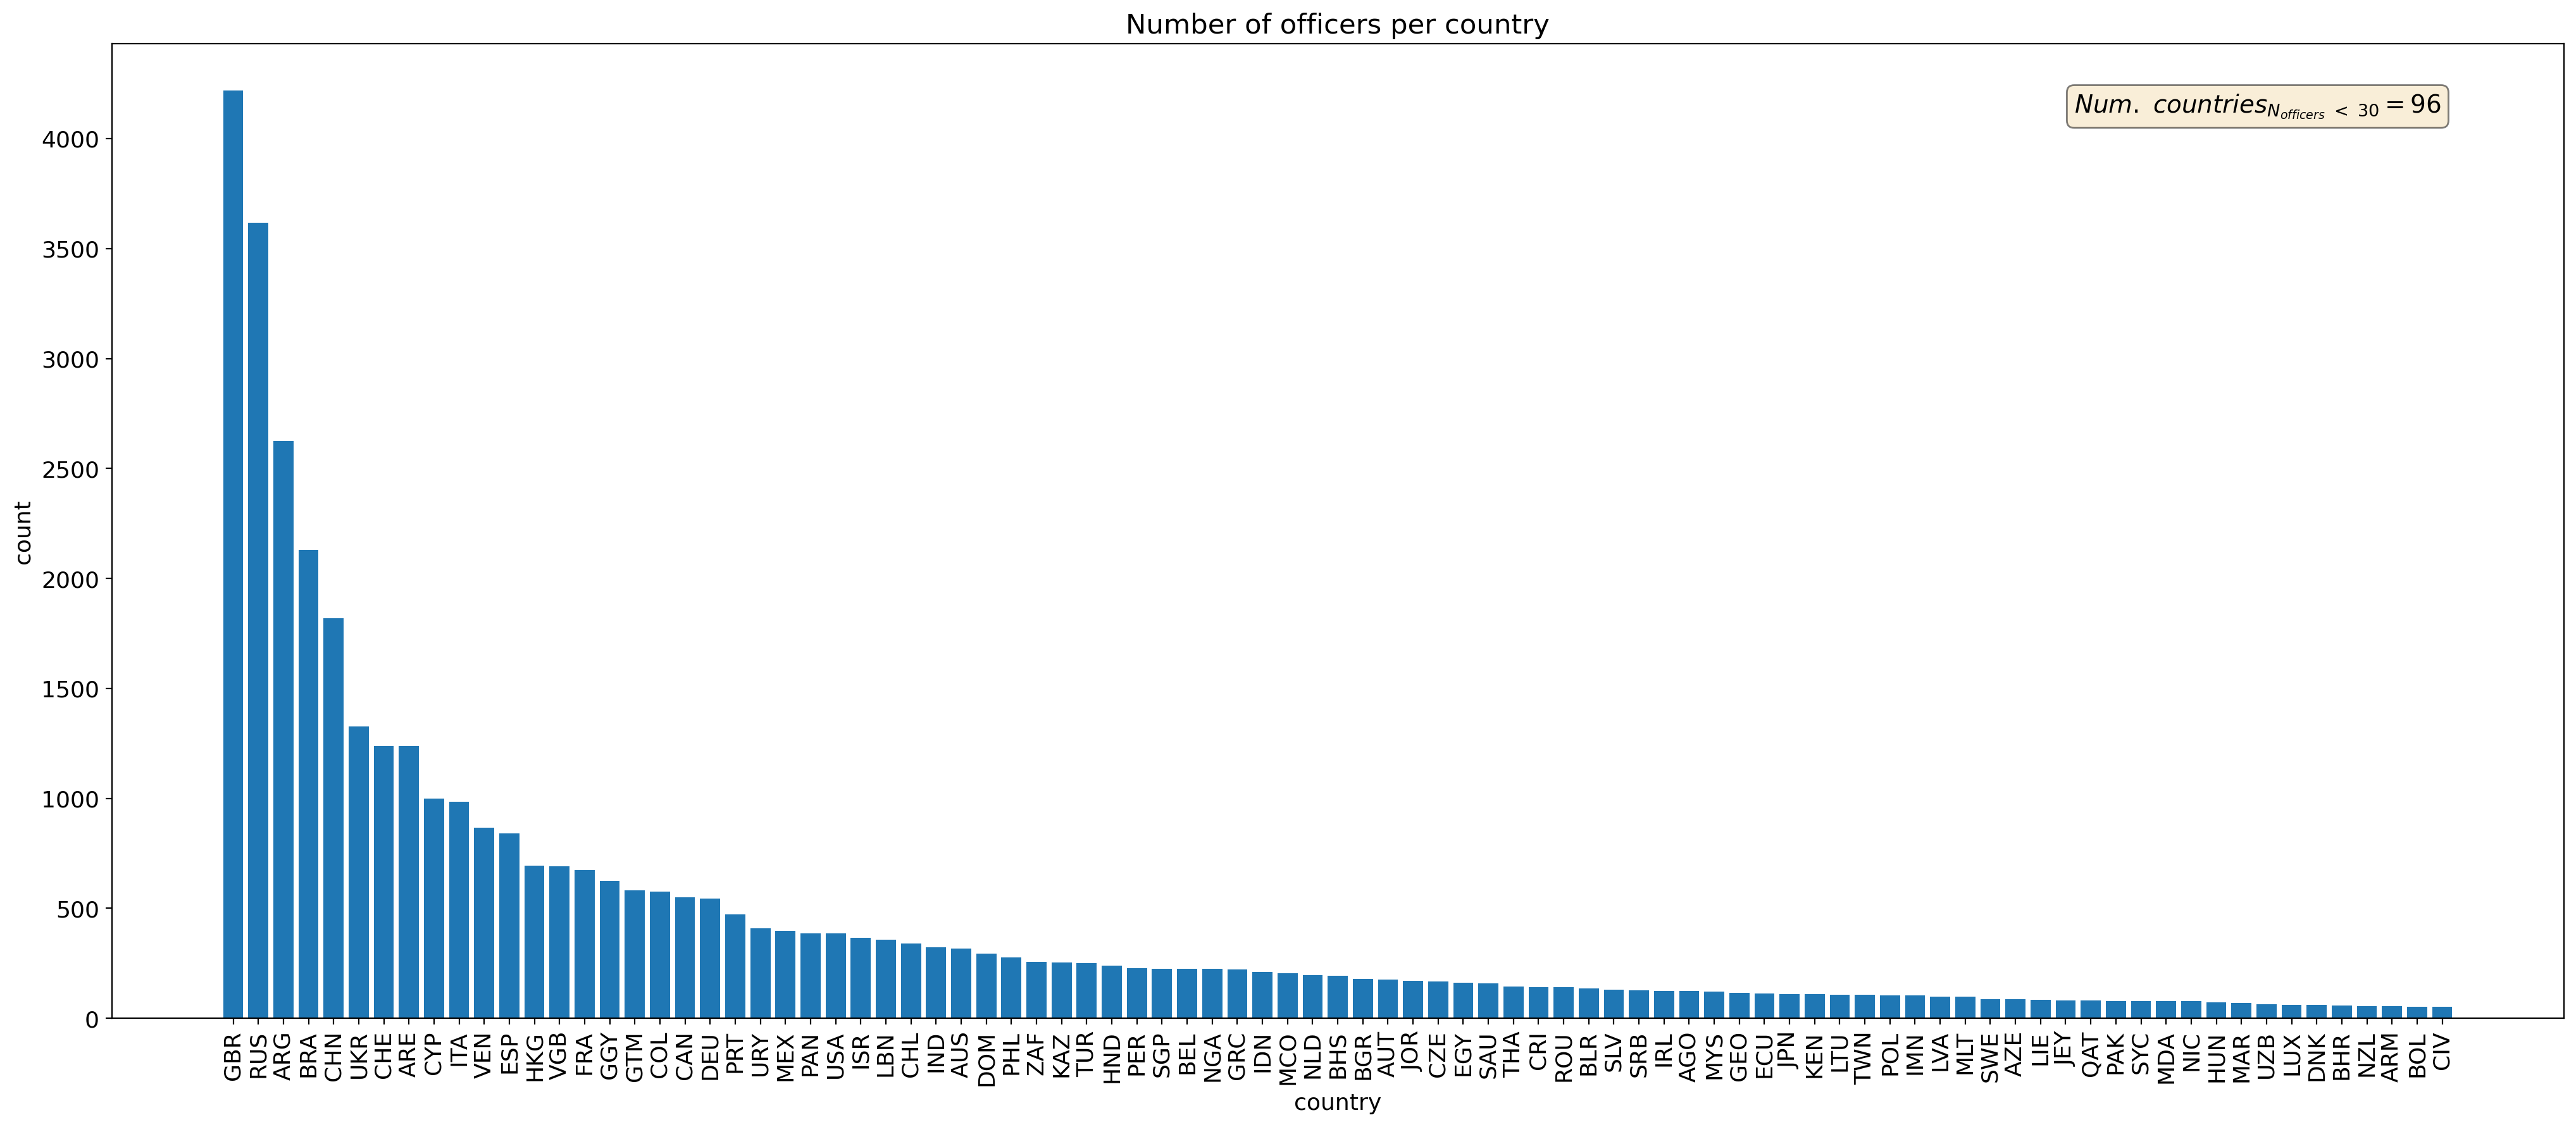

In [8]:
x, y = np.unique(
    [
        node.get("country_codes", "NA")
        for node in dict(officer_officer.nodes(data=True)).values()
    ],
    return_counts=True,
)

# sort by length
x = x[np.argsort(y)[::-1]]
y = y[np.argsort(y)[::-1]]

# only keep countries with more than 50 nodes
countries_exclude = np.sum(y <= 50)
x = x[y > 50]
y = y[y > 50]

_, ax = plt.subplots(1, 1)
ax.bar(x, y)

textstr = r"$Num.\ countries_{N_{officers}\ <\ 30}=%.0f$" % (countries_exclude,)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.95,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)

plt.xticks(rotation=90)
plt.title("Number of officers per country")
plt.xlabel("country")
plt.ylabel("count")
plt.show()

Im oberen Plot wurden 96 Länder (Anzahl Officers <= 50) entfernt um den Plot nicht zu überladen.  
Die meisten Officers sind von England, gefolgt von Russland und China.  
Die Schweiz sitzt auf dem achten Platz.

# Erstelle einen neuen Graphen, welcher nun die Länder als edges besitzt

In [9]:
same_country_graph = utils.graph_from_attr_name(officer_officer, "country_codes")

# Korrelation zwischen den Officer-beziehungen und Ländern

In [ ]:
result = utils.dyadic_hypothesis_test(officer_officer, same_country_graph, n=1000, n_jobs=20)

In [34]:
result

{'metric_original': 0.10944806599639749,
 'metrics_permuted': [0.00025548166871359383,
  -0.00026278810840377686,
  -0.00029152902141500075,
  0.0003329169158047382,
  -0.00040259190839683225,
  -0.0003572879596713928,
  0.0002715444754957824,
  -0.0001852796729892434,
  3.084667087967116e-05,
  0.00011950148986039683,
  0.00011720651218229468,
  -0.0002509439533883922,
  0.00033812870698050234,
  7.752782959406474e-05,
  -0.00010317831976275029,
  0.00043110448677822724,
  0.00022164803610543872,
  -7.956033753099404e-05,
  0.000271736521993479,
  8.533849286152972e-05,
  -0.00012014544605361442,
  5.0304497209592785e-05,
  0.00015748333690244757,
  -0.00035699844866816076,
  -1.841807457646406e-05,
  -0.0001580915948808621,
  9.84778588753113e-05,
  0.00040679857233459204,
  0.00048588632240501104,
  -1.4456704913151232e-05,
  -4.522105723161114e-06,
  0.00018001247659332395,
  -0.00015244499410703213,
  0.0003135867628681806,
  -0.00010097850028615217,
  -6.39230397573218e-05,
  0.0

## Hypothesentest

- Im Hypothesentest wird überprüft, ob der Rang der Schweiz bezüglich Interaktionsstärke mit den anderen Ländern statistisch signifikant ist (Irrtumswahrscheinlichkeit = 0.05).
- Auch die Interaktionsstärke selbst wird auf statistische Signifikanz überprüft.

Der Hypothesentest wird durch einen Permutationstest durchgeführt.  
Die gesamte Interaktionsstärke mit dem Ausland wird durch den Weighted Node Degree berechnet.  
Anschliessend werden die Kantengewiche des `G_contracted` Netzwerks zufällig vertauscht und die Interaktionsstärke und Rang der Schweiz neu berechnet.  
Diese Permutation wird 20'000 mal durchgeführt um die Verteilung der Interaktuonsstärke zu simulieren.

In [ ]:
def permutation_test_weighted_degree(G: nx.Graph, target_node: str, n: int = 20000):
    def get_deg_weight_rank(G: nx.MultiGraph, target_node: str):
        # calculate weighted degree and sort
        deg = np.array(list(G.degree(weight="weight"))).astype(float)
        deg_sorted = deg[deg[:, 1].argsort()[::-1]]

        # get index
        i = np.argwhere(deg_sorted[:, 0] == int(target_node))[0, 0]

        # get weight and rank
        weight = deg_sorted[i, 1]
        rank = i + 1

        return weight, rank

    # calculate original weight and rank of target node
    orig_weight, orig_rank = get_deg_weight_rank(G, target_node)

    runs = []
    for _ in tqdm(range(n)):
        # permute graph
        G_ = utils.permute_graph_QAP(G, self_loops=False)

        # calculate weight and rank of permuted graph
        w, r = get_deg_weight_rank(G_, target_node)

        runs.append({"weight": w, "rank": r})

    return {
        "original_weight": orig_weight,
        "original_rank": orig_rank,
    }, pd.DataFrame.from_records(runs)


original, permutations = permutation_test_weighted_degree(
    G_contracted.copy(), mapper["CHE"]
)

  0%|          | 0/20000 [00:00<?, ?it/s]

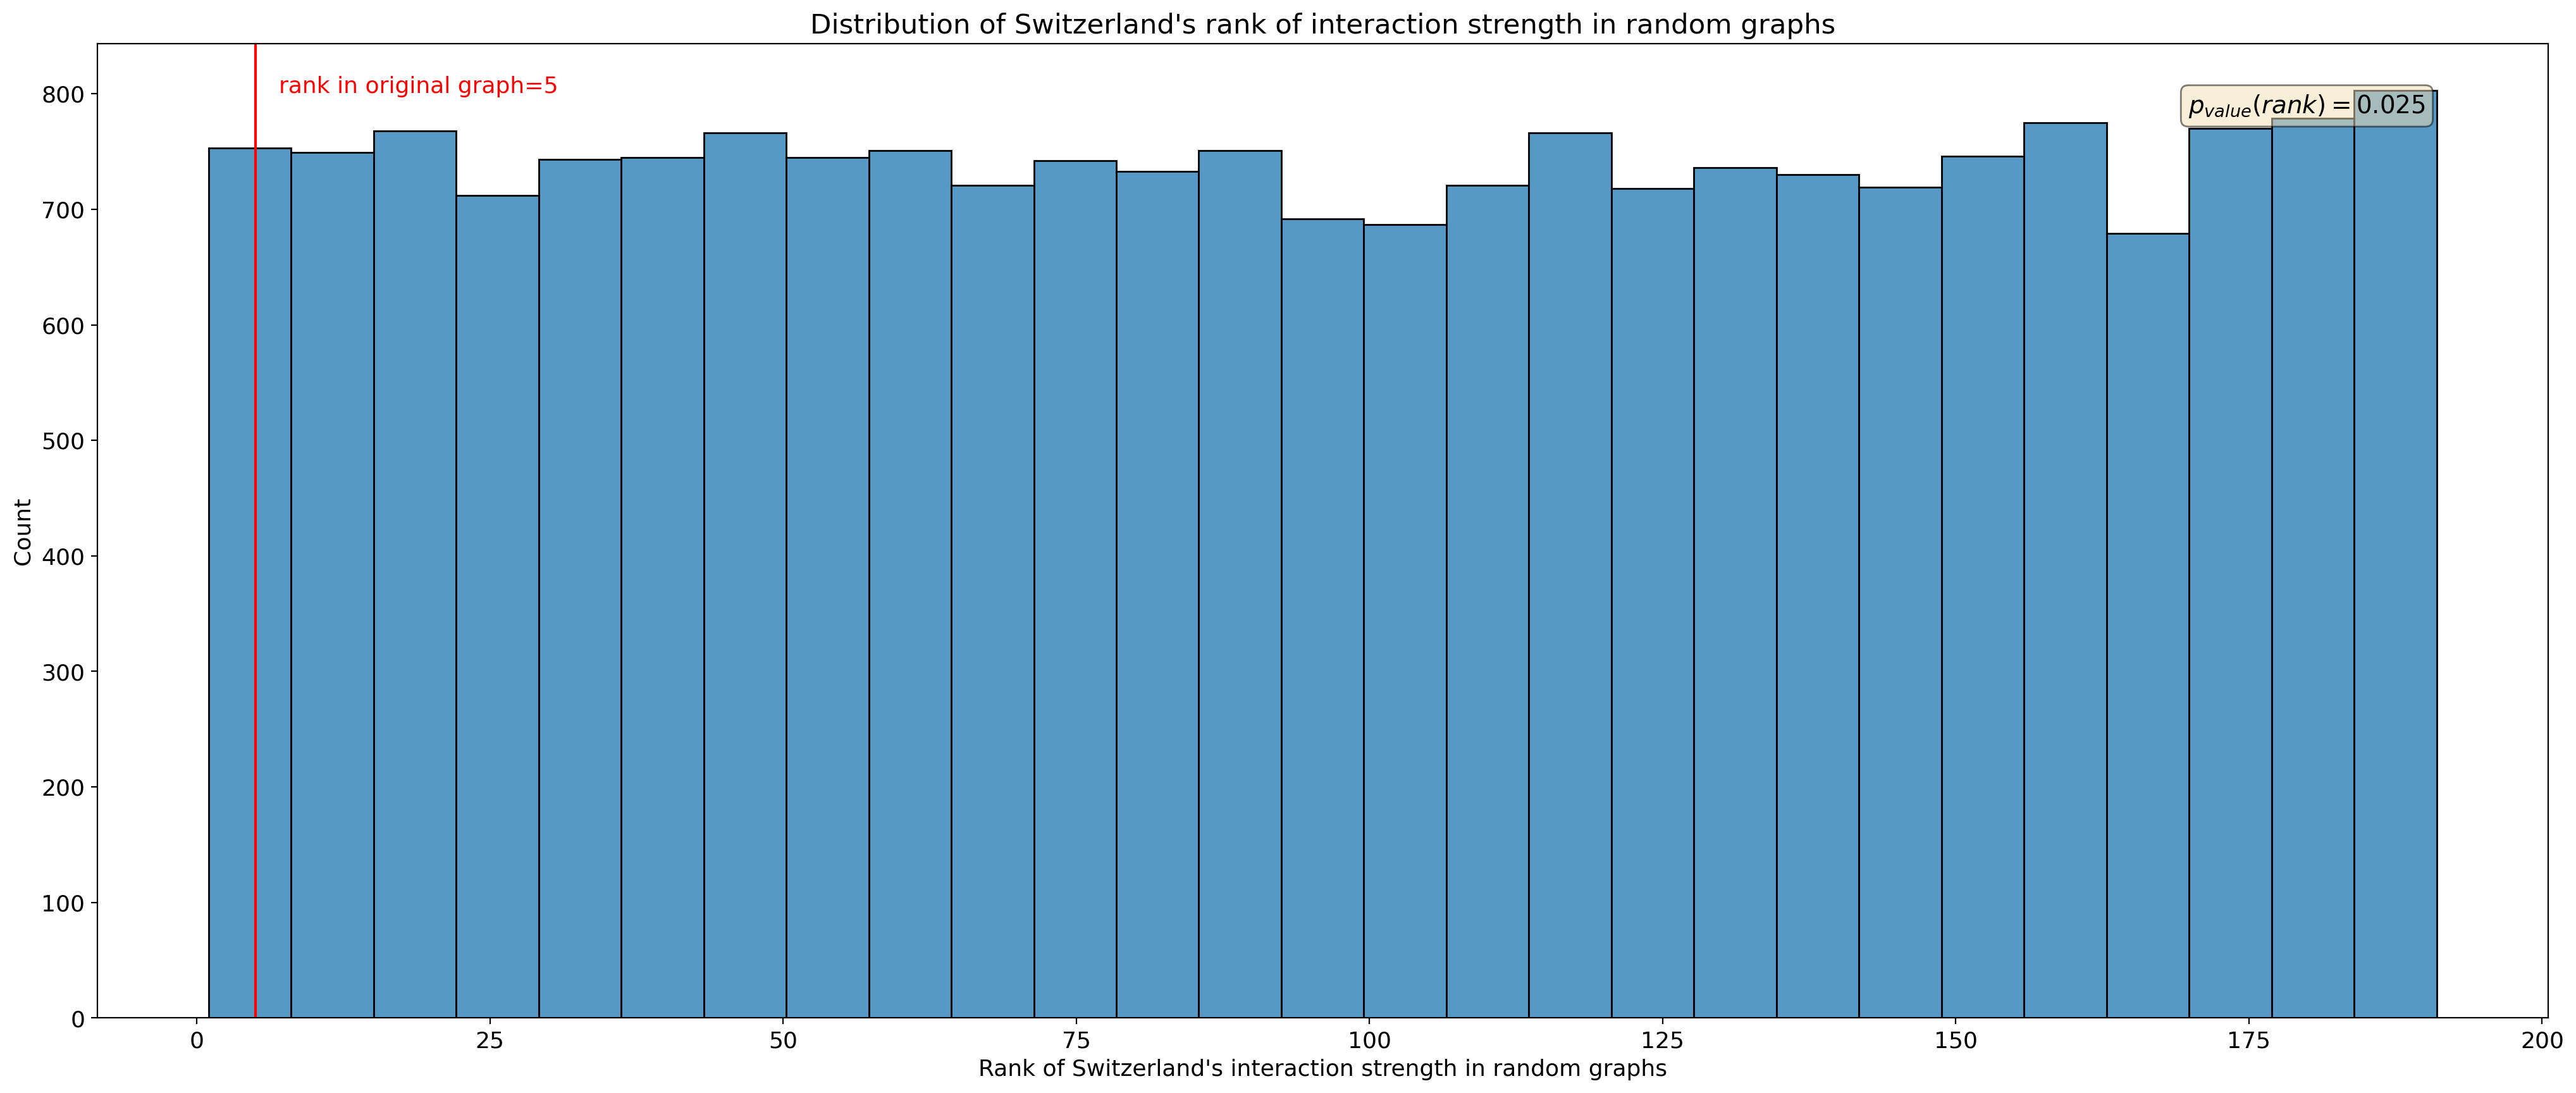

In [ ]:
ax = sns.histplot(permutations, x="rank")
plt.axvline(original["original_rank"], color="red")
plt.text(
    original["original_rank"] + 2,
    plt.gca().get_ylim()[1] * 0.95,
    "rank in original graph=" + str(original["original_rank"]),
    color="red",
)
plt.title("Distribution of Switzerland's rank of interaction strength in random graphs")

textstr = r"$p_{value}(rank)=%.3f$" % (
    (permutations["rank"] <= original["original_rank"]).sum() / len(permutations),
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.95,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)

plt.xlabel("Rank of Switzerland's interaction strength in random graphs")
plt.show()

Im obigen Plot sind die Ränge der Interaktionsstärke der Schweiz in zufälligen Graphen als Histogramm visualisiert. Die zufälligen Graphen wurden durch einen Permutationstest mit 20.000 Durchläufen erstellt. Nach jedem Durchlauf wurde der Rang der Schweiz neu berechnet. Dadurch kann der Rang der Schweiz in zufälligen Graphen simuliert werden und herausgefunden werden, in wie vielen Fällen der zufällige Rang kleiner oder gleich dem Rang im ursprünglichen Graphen ist. Dieses Histogramm zeigt die Verteilung des Ranges der Schweiz in zufälligen Graphen. Die rote Linie repräsentiert den Rang im ursprünglichen Graphen. Je weniger blaue Fläche sich links von der Linie befindet, desto kleiner ist der p-Wert und somit auch die Irrtumswahrscheinlichkeit.

Mit einem p-Wert von weniger als 0,05 ist der ursprüngliche Rang von 5 statistisch signifikant.

$$
\begin{align*}
H_0 &: r \geq r_{\text{zufällig}} \\
H_1 &: r < r_{\text{zufällig}}
\end{align*}
$$

Somit kann behaupten werden, dass die Schweiz zu den Spitzenreitern bezüglich der Interaktionsstärke mit anderen Ländern gehört.

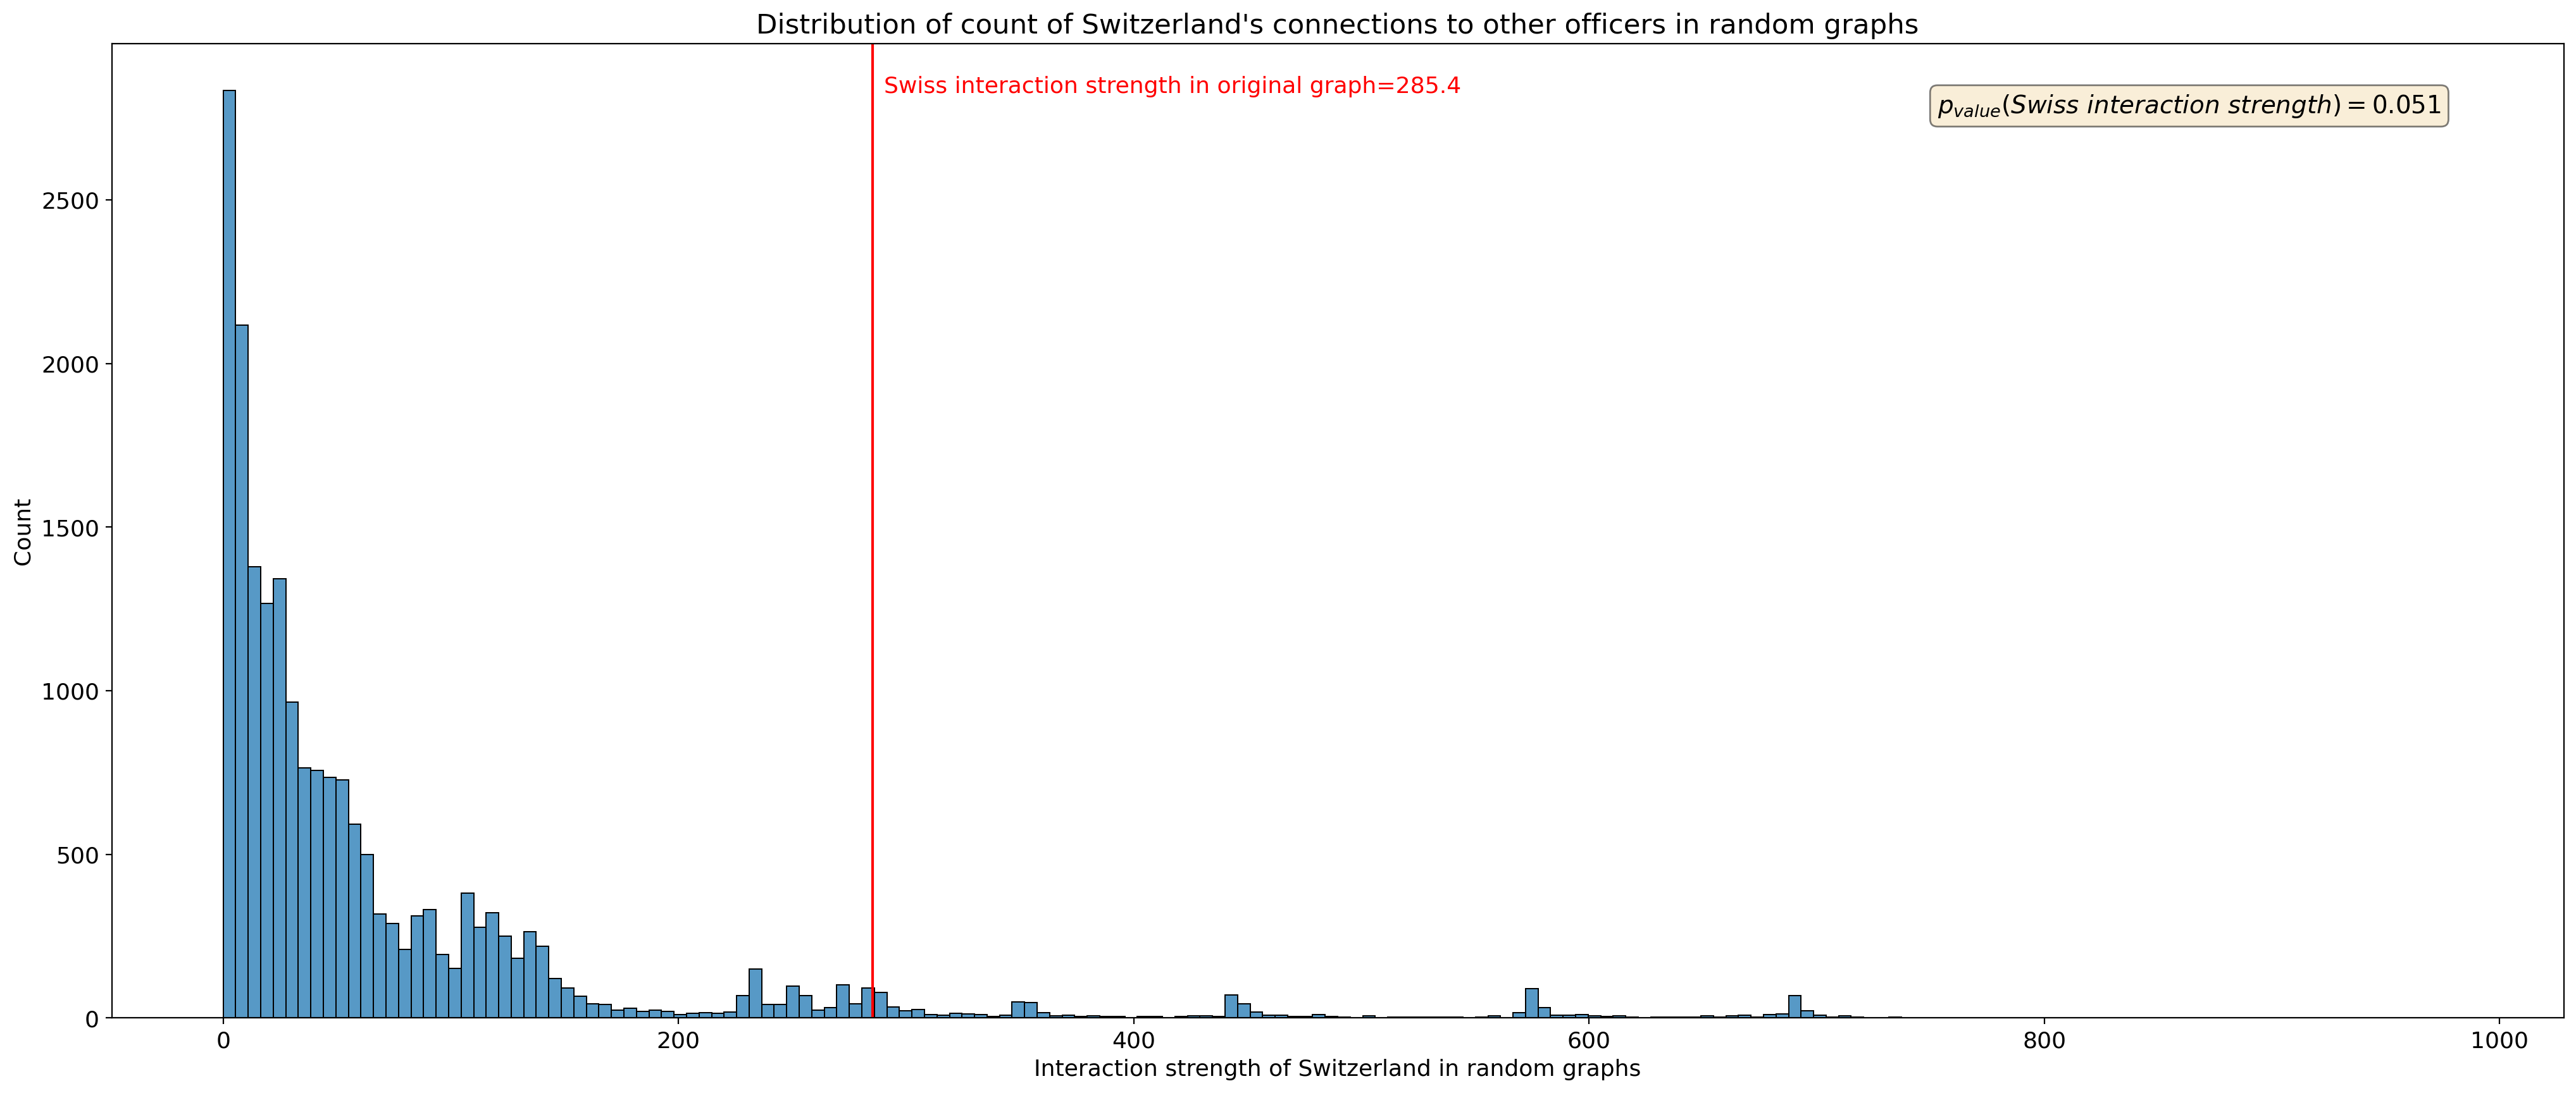

In [ ]:
ax = sns.histplot(permutations, x="weight")
plt.axvline(original["original_weight"], color="red")
plt.text(
    original["original_weight"] + 5,
    plt.gca().get_ylim()[1] * 0.95,
    "Swiss interaction strength in original graph="
    + str(round(original["original_weight"], 1)),
    color="red",
)
plt.title(
    "Distribution of count of Switzerland's connections to other officers in random graphs"
)

textstr = r"$p_{value}(Swiss\ interaction\ strength)=%.3f$" % (
    (permutations["weight"] >= original["original_weight"]).sum() / len(permutations),
)
props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.95,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)

plt.xlabel("Interaction strength of Switzerland in random graphs")
plt.show()

Im obigen Plot ist die Verteilung der Interaktionsstärke (Edge Weight) der Schweiz in zufälligen Graphen als Histogramm dargestellt. Diese zufälligen Graphen wurden ebenfalls durch einen Permutationstest mit 20.000 Durchläufen erstellt. Die rote Linie repräsentiert die Interaktionsstärke der Schweiz im ursprünglichen Graphen. Je weniger blaue Fläche sich rechts von der roten Linie befindet, desto besser, da dies einen kleineren p-Wert und somit eine geringere Irrtumswahrscheinlichkeit bedeutet.

Bei Betrachtung der Interaktionsstärke selbst liegt der p-Wert nahe an der Grenze zur statistischen Signifikanz. Dass der Rang statistisch signifikant ist, ist möglich, weil beim Rang die tatsächliche Interaktionsstärke der einzelnen Ländern nicht berücksichtigt wird.

$$
\begin{align*}
H_0 &: \text{Interaktionsstärke} \leq \text{Interaktionsstärke}_{\text{zufällig}} \\
H_1 &: \text{Interaktionsstärke} > \text{Interaktionsstärke}_{\text{zufällig}}
\end{align*}
$$

Dies zeigt, dass die Schweiz in Bezug auf die Interaktionsstärke eine herausragende Position einnimmt, obwohl die Signifikanzgrenze knapp ist.
